In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
stoi = {chr(i+96):i for i in range(1,27)}
stoi['.']=0
itos = {i:c for c,i in stoi.items()}
print(stoi)
print(itos)
vocab_size = len(stoi)
vocab_size

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


27

In [5]:
block_size = 3

def build_dataset(words):
  X, Y = [],[]

  for word in words:
    context = [0]*block_size
    for c in word+'.':
      i = stoi[c]
      X.append(context)
      Y.append(i)
      context = context[1:] + [i]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y


random.seed(40)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182469, 3]) torch.Size([182469])
torch.Size([22751, 3]) torch.Size([22751])
torch.Size([22926, 3]) torch.Size([22926])


In [ ]:
from types import GeneratorType
n_emb = 10 # character is embeded in n_emb dimentionality using C lookup matrix
n_hidden = 200 # num of neurons in a hidden layer

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(vocab_size, n_emb,           generator=g) # look up matrix to embed char in higher dimentionality
W1 = torch.randn(n_emb*block_size, n_hidden, generator=g)*(5/3)/((n_emb*block_size)**0.5)
b1 = torch.randn(n_hidden,                   generator=g)*0.01
W2 = torch.randn(n_hidden, vocab_size,       generator=g)*0.01
b2 = torch.randn(vocab_size,                 generator=g)*0

# batch normalization gain and bais
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True




12297


In [ ]:
# We want initial probabilites to be almost same, as every character have same chances to come next
# scalling help us to do this
# otherwise we have a very large loss initially, which we don't want
# if we initialize all weights and biases tf symmetry, now all no zero?
# we get the problem oeurons will behave same, which kills the learning
# Thats why initialize weights with small random values

logits = torch.randn(4)
scaled_logits = logits*0.01

print("probabilities without scalling   -", torch.softmax(logits, dim=0))
print("probabilities with scalling      -", torch.softmax(scaled_logits, dim=0))

probabilities without scalling   - tensor([0.3422, 0.5672, 0.0784, 0.0122])
probabilities with scalling      - tensor([0.2527, 0.2540, 0.2490, 0.2444])


In [ ]:
# dividing with sqrt of fan_in keeps the std same

w = torch.randn(50, 1000)/(50**0.5)
x = torch.randn(10, 50)
xw = x@w
print("std of xw ", xw.std())


std of xw  tensor(0.9437)


In [ ]:
#hpreact = bn_gain*(hpreact - hpreact.mean(dim=0,keepdim=True))/hpreact.std(dim=0,keepdim=True) + bn_bias

# this line works perfectly fine but has a limitation
# We can run it for single example (eg batch size = 1)
# why? Because, std = 0
# During inference, we only pass one example at a time

In [ ]:
steps = 200000
batch_size = 32
lossi = []
for i in range(steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # 32 values b/w 0 and len(Xtr)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb] # this embeds the character in higher dimensions
  embcat = emb.view(batch_size, -1) # view in (32, 3*10)
  hpreact = embcat@W1 + b1 # hidden layer pre-activation

  # dim = 0 because each column is a neuron so we have each neuron normalized
  #hpreact = bn_gain*(hpreact - hpreact.mean(dim=0,keepdim=True))/hpreact.std(dim=0,keepdim=True) + bn_bias

  bn_meani = hpreact.mean(dim=0, keepdim=True)
  bn_stdi = hpreact.std(dim=0, keepdim=True)
  hpreact = bn_gain*(hpreact - bn_meani)/bn_stdi + bn_bias

  with torch.no_grad():
    bn_mean_running = 0.999*bn_mean_running + 0.001*bn_meani
    bn_std_running = 0.999*bn_std_running + 0.001*bn_stdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h@W2 + b2  # output layer
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if(i%10000==0):
    print(f'{i}/{steps} : {loss.item()}')
  lossi.append(loss.log10().item())
  #break

0/200000 : 2.2869815826416016
10000/200000 : 1.9208528995513916
20000/200000 : 2.168670654296875
30000/200000 : 2.1945438385009766
40000/200000 : 2.1126270294189453
50000/200000 : 1.7850325107574463
60000/200000 : 2.0172572135925293
70000/200000 : 2.400668144226074
80000/200000 : 1.997697114944458
90000/200000 : 1.8936949968338013
100000/200000 : 2.3072524070739746
110000/200000 : 2.0807504653930664
120000/200000 : 1.9805960655212402
130000/200000 : 2.096867322921753
140000/200000 : 2.233393669128418
150000/200000 : 2.116150140762329
160000/200000 : 1.7575745582580566
170000/200000 : 2.2748332023620605
180000/200000 : 2.161651134490967
190000/200000 : 1.784900426864624


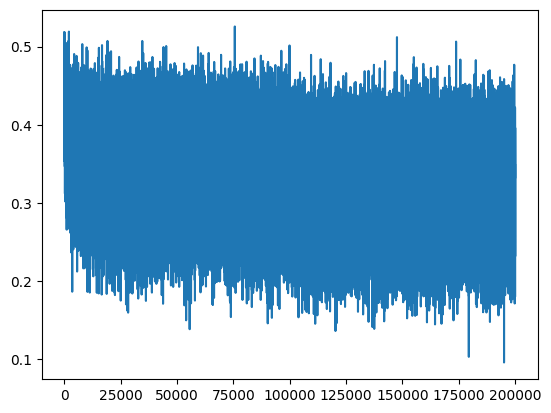

In [ ]:
plt.plot(lossi)

# not getting a hockey like shape because initially loss is not very high

In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat@W1+b1

  # mean and std over entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

  print(bnmean[0,:5])
  print(bn_mean_running[0,:5])

# bnmean/std and bn_mean/std_running are same
# So we don't need to calculate bnmean/std explicitly

tensor([-2.1233,  0.3418, -0.9176,  1.2350,  0.9149])
tensor([-2.1193,  0.3477, -0.9069,  1.2439,  0.9185])


In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train' : (Xtr, Ytr),
    'val' : (Xdev, Ydev),
    'test' : (Xte, Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat@W1 + b1
  #hpreact = bn_gain*(hpreact - hpreact.mean(dim=0,keepdim=True))/hpreact.std(dim=0,keepdim=True) + bn_bias
  hpreact = bn_gain*(hpreact - bn_mean_running)/bn_std_running + bn_bias
  h = torch.tanh(hpreact)
  logits = h@W2 + b2
  loss = F.cross_entropy(logits, y)

  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.050867795944214
val 2.1051714420318604


In [ ]:
for _ in range(10):
  out = ""
  context = [0]*block_size
  while(True):
    emb = C[torch.tensor([context])]
    embcat = emb.view(1, -1)
    hpreact = embcat@W1 + b1
    hpreact = bn_gain*(hpreact-bn_mean_running)/bn_std_running + bn_bias
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    probs = torch.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    out += itos[ix]
    context = context[1:] + [ix]

    if(ix==0):
      break
  print(out)



kayleen.
norie.
adallianna.
ker.
lea.
michorrendo.
avier.
siya.
shayli.
ston.


In [ ]:
# Deeper Neural Network

In [28]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.w = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
    self.b = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x@self.w
    if self.b is not None:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.w] + ([] if self.b is None else [self.b])

class BatchNom1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backpropogation
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    #calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance and mean zero
    self.out = self.gamma*xhat + self.beta

    # upadat the buffer
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar

    return self.out

  def parameters(self):
      return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

n_emb = 10
n_hidden = 100  # number of neurons in hidden layer
g = torch.Generator().manual_seed(122345)

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb*block_size, n_hidden),   BatchNom1d(n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden),   BatchNom1d(n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden),   BatchNom1d(n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden),   BatchNom1d(n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden),   BatchNom1d(n_hidden), Tanh(),
    Linear(        n_hidden, vocab_size), BatchNom1d(vocab_size),
]

with torch.no_grad():
  # last lyaer : make less confident
  # layers[-1].w *= 0.1
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.w *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True


47551


In [29]:

steps = 200000
batch_size = 32
lossi=[]

for i in range(steps):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb , Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  # for layer in layers:
  #   layer.out.retain_grad()

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr*p.grad

  if(i%10000==0):
    print(f'{i}/{steps} : {loss.item()}')
  lossi.append(loss.log10().item())



0/200000 : 3.2777090072631836
10000/200000 : 1.9703110456466675
20000/200000 : 2.0321009159088135
30000/200000 : 2.1504909992218018
40000/200000 : 2.063553810119629
50000/200000 : 2.1958816051483154
60000/200000 : 2.7134478092193604
70000/200000 : 2.283964157104492
80000/200000 : 2.131430149078369
90000/200000 : 1.9675531387329102
100000/200000 : 2.3167784214019775
110000/200000 : 2.2899599075317383
120000/200000 : 2.1050589084625244
130000/200000 : 2.242170810699463
140000/200000 : 1.9601836204528809
150000/200000 : 2.3128416538238525
160000/200000 : 2.1453051567077637
170000/200000 : 2.124255657196045
180000/200000 : 1.902509093284607
190000/200000 : 2.0206470489501953


In [30]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into evaluation mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0134880542755127
val 2.0845770835876465


In [31]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)

      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)

      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montaymyah.
seel.
nd.
rylla.
emmadiekdra.
grace.
kamelin.
shi.
jenne.
eiseananaraelyzirhota.
cayshab.
roshirael.
kin.
renleigh.
teron.
ubakard.
ryy.
julieh.
yuma.
myston.
